In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from project_utils import utils
from project_utils import read_utils as read

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
input_length = [12, 12, 12, 60]
obs_dates = utils.load_dates(dataset="ERSSTv5")
gcm_dates = utils.load_dates()
lats, lons = utils.load_lat_lon()
na_lats = np.array([lats[0:5], lats[-5:]]).reshape(-1)

from project_utils.variant_dict import VARIANT_DICT, test_index

In [5]:
model_list=["ACCESS-ESM1-5", "CanESM5", "CNRM-CM6-1", "GISS-E2-1-G", 
            "IPSL-CM6A-LR", "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-LR", "NorCPM1"]
leads = [0, 0, 24]
prediction_lengths = [36, 60, 60]
seeds = [101, 121, 505]
y_var = "tos"

### Calculate accuracy on GCM test simulations

In [6]:
for MODEL in model_list:
    print(MODEL)
    test_variants = VARIANT_DICT[MODEL][test_index]   
    for lead, length in zip(leads, prediction_lengths):
        _, _, prediction_dates = utils.get_prediction_dates(gcm_dates, input_length,lead,
                                                    length)
        _, y_test = read.load_xy_data(gcm_dates, input_length, lead, length, "tos", y_var,
                         test_variants, MODEL)
        y_test = xr.DataArray(data = y_test.reshape(len(test_variants), len(prediction_dates), len(lats), len(lons)), 
                      coords = dict(variant = test_variants, time = prediction_dates, lat = lats, lon = lons), 
                      name = y_var)
        y_quantiles = read.read_data(y_var, MODEL, 
                             length, VARIANTS = test_variants, stat = "quantiles", as_xarray=True)

        accuracy_list = []
        accuracy40_list = []
        accuracy20_list = []
        for SEED in seeds:
            model_predictions = xr.open_dataset("../processed_data/training/"+y_var+"_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"-trained_"+MODEL+"-predictions_"+str(SEED)+".nc")
            accuracy_list.append(utils.calc_accuracy(model_predictions, y_test, y_quantiles, by_variant=True).rename("SEED_"+str(SEED)))
            accuracy40_list.append(utils.calc_accuracy(model_predictions, y_test, y_quantiles, conf_q = 0.6, by_variant=True).rename("SEED_"+str(SEED)))
            accuracy20_list.append(utils.calc_accuracy(model_predictions, y_test, y_quantiles, conf_q = 0.8, by_variant=True).rename("SEED_"+str(SEED)))
            
        best_seed = xr.open_dataset("../processed_data/training/"+y_var+"_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"_best_seed.nc")
        accuracy_ds = xr.where(best_seed.best_seed == 0, accuracy_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy_list[1], accuracy_list[2])).rename("score")
        accuracy40_ds = xr.where(best_seed.best_seed == 0, accuracy40_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy40_list[1], accuracy40_list[2])).rename("score")
        accuracy20_ds = xr.where(best_seed.best_seed == 0, accuracy20_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy20_list[1], accuracy20_list[2])).rename("score")

        accuracy_ds.to_netcdf("../processed_data/accuracy/GCM_accuracy_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")
        accuracy40_ds.to_netcdf("../processed_data/accuracy/GCM_accuracy_top40_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")
        accuracy20_ds.to_netcdf("../processed_data/accuracy/GCM_accuracy_top20_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")

ACCESS-ESM1-5
CanESM5
CNRM-CM6-1
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
NorCPM1


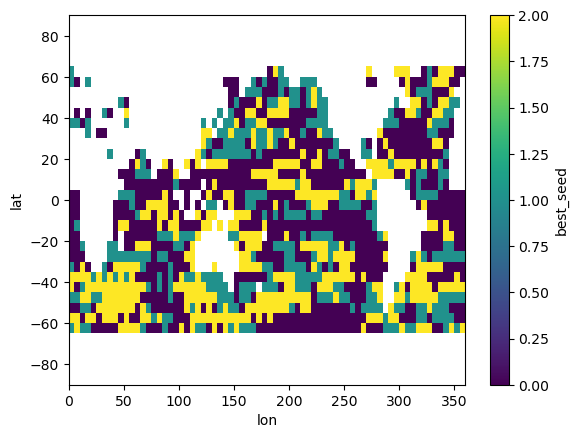

In [8]:
best_seed.best_seed.plot()

### Calculate accuracy on ERSSTv5 observations

In [10]:
for lead, length in zip(leads, prediction_lengths):
    _, _, prediction_dates = utils.get_prediction_dates(obs_dates, input_length, lead, length)
    _, y_obs = read.load_xy_obs(obs_dates, input_length, lead, length, 
                              X_VAR_NAME = "sst", Y_VAR_NAME = "sst", 
                                 DATASET="ERSSTv5")
    y_obs = xr.DataArray(data = y_obs.reshape(1, len(prediction_dates), len(lats), len(lons)), 
                      coords = dict(variant = ["obs_variant"], time = prediction_dates, lat = lats, lon = lons), 
                      name = "tos")
    y_obs.loc[dict(lat=na_lats)] = np.nan

    y_quantiles = xr.open_dataset("../processed_data/ERSSTv5/sst_5x5_"+str(length)+"month_quantiles.nc").rename_dims(
        {"quantile":"q"})

    for MODEL in model_list:
        print(MODEL) 

        accuracy_list = []
        accuracy40_list = []
        accuracy20_list = []
        for SEED in seeds:
            model_predictions = xr.open_dataset("../processed_data/training/tos_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"-trained_ERSSTv5-predictions_"+str(SEED)+".nc")
            accuracy_list.append(utils.calc_accuracy(model_predictions, y_obs, y_quantiles))
            accuracy40_list.append(utils.calc_accuracy(model_predictions, y_obs, y_quantiles, conf_q = 0.6))
            accuracy20_list.append(utils.calc_accuracy(model_predictions, y_obs, y_quantiles, conf_q = 0.8))
            
        best_seed = xr.open_dataset("../processed_data/training/tos_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"_best_seed.nc")
        accuracy_ds = xr.where(best_seed.best_seed == 0, accuracy_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy_list[1], accuracy_list[2])).rename({"sst":"score"})
        accuracy40_ds = xr.where(best_seed.best_seed == 0, accuracy40_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy40_list[1], accuracy40_list[2])).rename({"sst":"score"})
        accuracy20_ds = xr.where(best_seed.best_seed == 0, accuracy20_list[0], 
                               xr.where(best_seed.best_seed == 1, accuracy20_list[1], accuracy20_list[2])).rename({"sst":"score"})

        accuracy_ds.to_netcdf("../processed_data/accuracy/ERSSTv5_accuracy_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")
        accuracy40_ds.to_netcdf("../processed_data/accuracy/ERSSTv5_accuracy_top40_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")
        accuracy20_ds.to_netcdf("../processed_data/accuracy/ERSSTv5_accuracy_top20_"+MODEL+\
                          "_"+str(length)+"mo_"+str(lead)+"lead.nc")

ACCESS-ESM1-5
CanESM5
CNRM-CM6-1
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
NorCPM1
ACCESS-ESM1-5
CanESM5
CNRM-CM6-1
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
NorCPM1
ACCESS-ESM1-5
CanESM5
CNRM-CM6-1
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
NorCPM1
